Using Colab cache for faster access to the 'flight-delays' dataset.


/tmp/ipython-input-1222902511.py:81: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



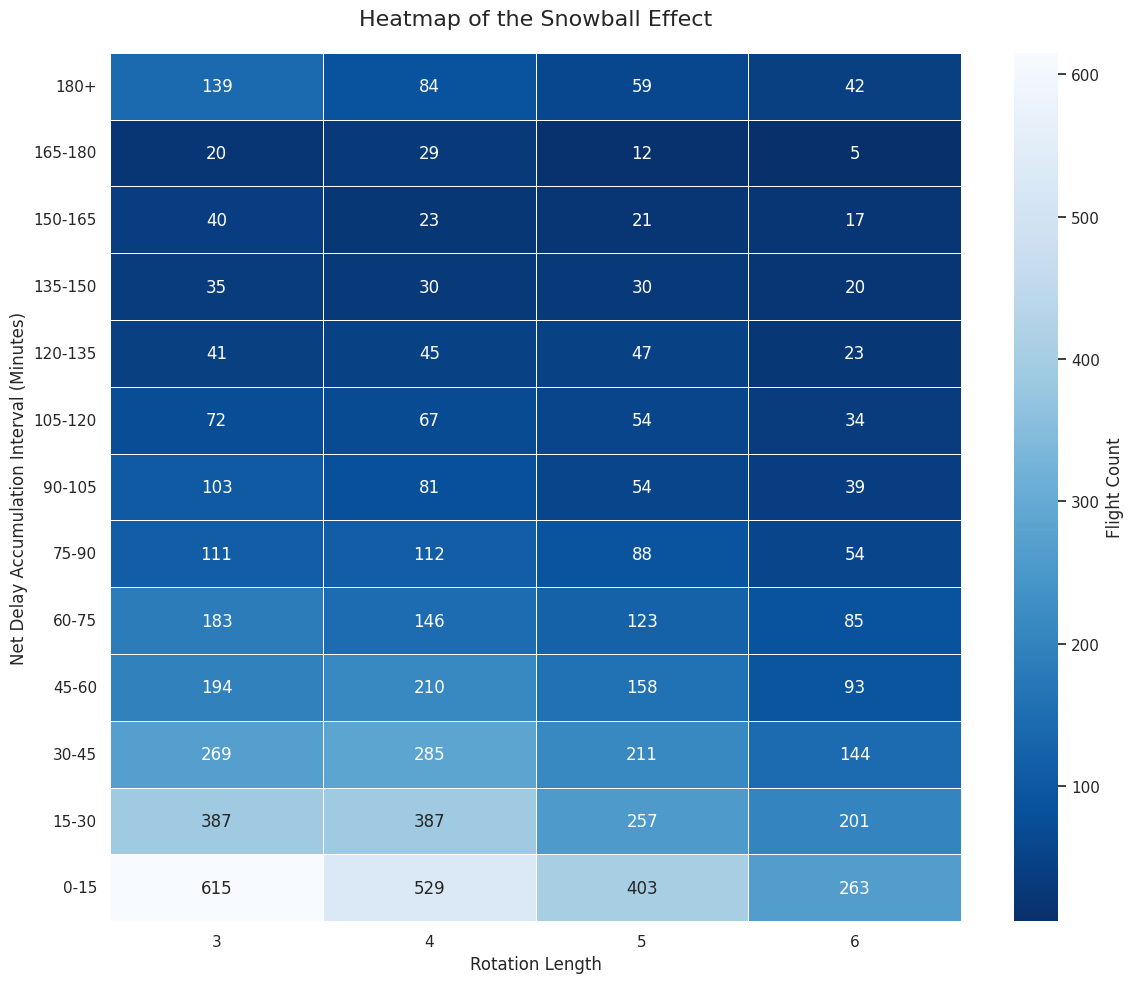

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import glob

# --- 1. DATA ACQUISITION & DISCOVERY ---
# Download the latest US DOT Flight Delays dataset via kagglehub
path = kagglehub.dataset_download("usdot/flight-delays")
flights_file = glob.glob(os.path.join(path, "**/flights.csv"), recursive=True)[0]

# Load essential columns only to minimize memory usage
cols = ['YEAR', 'MONTH', 'DAY', 'TAIL_NUMBER', 'SCHEDULED_DEPARTURE',
        'DEPARTURE_DELAY', 'ARRIVAL_DELAY']
df = pd.read_csv(flights_file, usecols=cols, low_memory=False)

# --- 2. DATA CLEANING & SEQUENCING ---
# Remove rows with missing identifiers or delay metrics
df = df.dropna(subset=['TAIL_NUMBER', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY'])
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])

# Sort flights chronologically for each specific aircraft (Tail Number)
df = df.sort_values(['TAIL_NUMBER', 'DATE', 'SCHEDULED_DEPARTURE'])

# Calculate the total flights per day and the specific sequence (Order) of each flight
grouped = df.groupby(['DATE', 'TAIL_NUMBER'])
df['DAILY_FLIGHT_COUNT'] = grouped['TAIL_NUMBER'].transform('count')
df['FLIGHT_ORDER'] = grouped.cumcount() + 1

# --- 3. SNOWBALL EFFECT LOGIC (FIRST vs. LAST FLIGHT) ---
# Filtering FIRST FLIGHTS:
# Constraints: Delay between 30-90 min AND rotation length of at least 3 flights
first_flights = df[
    (df['FLIGHT_ORDER'] == 1) &
    (df['DAILY_FLIGHT_COUNT'] >= 3) &
    (df['DEPARTURE_DELAY'] > 30) &
    (df['DEPARTURE_DELAY'] <= 90)
].copy()

# Filtering LAST FLIGHTS of the same day for the same aircraft
last_flights = df[df['FLIGHT_ORDER'] == df['DAILY_FLIGHT_COUNT']].copy()

# Merge First and Last flights to calculate the net delay progression
merged_analysis = pd.merge(
    first_flights[['DATE', 'TAIL_NUMBER', 'DEPARTURE_DELAY', 'DAILY_FLIGHT_COUNT']],
    last_flights[['DATE', 'TAIL_NUMBER', 'ARRIVAL_DELAY']],
    on=['DATE', 'TAIL_NUMBER'],
    how='inner'
).rename(columns={
    'DEPARTURE_DELAY': 'FIRST_DEPARTURE_DELAY',
    'ARRIVAL_DELAY': 'LAST_ARRIVAL_DELAY'
})

# Calculate Net Delay Change (Total delay accumulated or recovered throughout the day)
merged_analysis['DELAY_CHANGE'] = merged_analysis['LAST_ARRIVAL_DELAY'] - merged_analysis['FIRST_DEPARTURE_DELAY']

# --- 4. HEATMAP PREPARATION ---
# Focus on positive Snowball cases (where delay increased) for rotations between 3 and 6 flights
snowball_cases = merged_analysis[
    (merged_analysis['DELAY_CHANGE'] > 0) &
    (merged_analysis['DAILY_FLIGHT_COUNT'] >= 3) &
    (merged_analysis['DAILY_FLIGHT_COUNT'] <= 6)
].copy()

# Define Net Delay Accumulation intervals for the Y-axis (15-minute bins)
bins = list(np.arange(0, 195, 15))
bins.append(np.inf)
labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-2)]
labels.append("180+")

snowball_cases['DELAY_INTERVAL'] = pd.cut(
    snowball_cases['DELAY_CHANGE'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Construct Pivot Table for Heatmap visualization
heatmap_data = snowball_cases.pivot_table(
    index='DELAY_INTERVAL',
    columns='DAILY_FLIGHT_COUNT',
    values='TAIL_NUMBER',
    aggfunc='count'
).fillna(0).astype(int)

# Reorder index to display highest delays at the top for intuitive reading
heatmap_data = heatmap_data.reindex(labels[::-1])

# --- 5. VISUALIZATION: SNOWBALL INTENSITY HEATMAP ---
plt.figure(figsize=(12, 10))
sns.set_theme(style="white")

# Plotting with the requested color palette (Blues_r: Dark to Light)
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt="d",
    cmap="Blues_r",
    linewidths=.5,
    cbar_kws={'label': 'Flight Count'}
)

# English titles and axis labels
plt.title('Heatmap of the Snowball Effect', fontsize=16, pad=20)
plt.xlabel('Rotation Length', fontsize=12)
plt.ylabel('Net Delay Accumulation Interval (Minutes)', fontsize=12)

# Save the final output as a high-resolution PNG
plt.tight_layout()
plt.savefig('RQ1_Snowball_Intensity_Heatmap.png', dpi=300)
plt.show()